# Ultrasounds data augmentation

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

from src.data.image import Ultrasound, Image
from src.data.data_transforms import Resize, DynamicRangeScaling, Compose, RandomNoise, Blur, AxisTranspose, FDATransform
from src.data.us_dataset import UsDataset, split_us_dataset
from src.models.clasifier_model import ImageClassifier
from src.models.classifier_trainer import ClassifierTrainer
from src.options.classifier_options import ClassifierOptions
from src.utils import load_us_data, obtain_histogram

labels = {
        "bladder": 0,
        "bowel": 1,
        "gallbladder": 2,
        "kidney": 3,
        "liver": 4,
        "spleen": 5,
    }
inverse_labels = {label: key for key, label in labels.items()}

data = load_us_data()

## 1. Data Exploration 

Before everything, we must look for a good cone segmentation and save it. It will be used for all images in USnotAI dataset, since all of them have the same orientation.

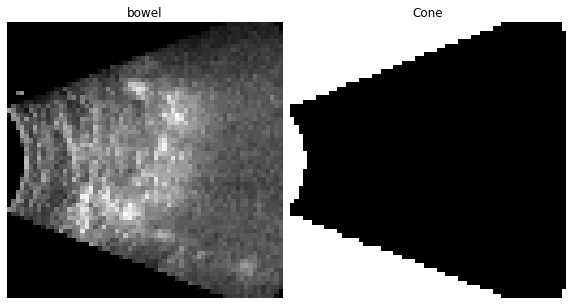

In [2]:
image_number = 5
us = data[image_number]
cone = Image(us.cone_array, "Cone")
f = Image.create_image_grid([us,cone])

This image was selected as cone reference. Results were saved in cone.png. Now, when data is loaded, selected cone is loaded with all images. Now, let's study the dataset statistics

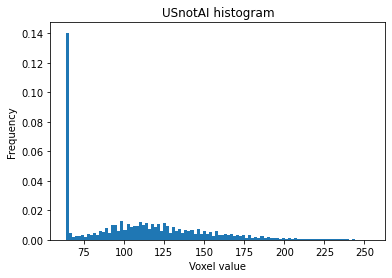

In [4]:
hist = obtain_histogram(data, sample_size=40, title="USnotAI histogram")

## 2. Traininig a classifier for USnotAI

Once we have some insights on the data, we can start training the classification model. It will be the base of all of our work since we need to evaluate ints performance in datasets out of its domain and how data harmonization helps.

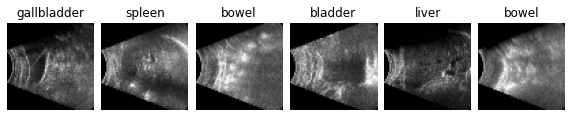

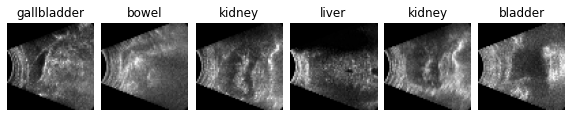

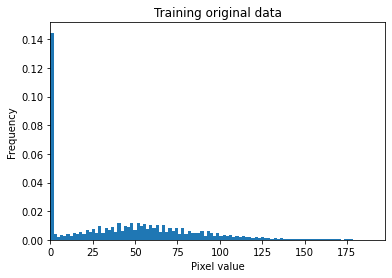

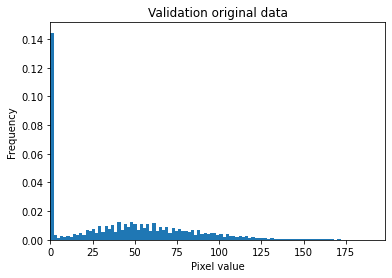

In [9]:
data = load_us_data()
train_data, validation_data = split_us_dataset(data, labels.keys(), 0.2)
f = Ultrasound.create_image_grid(train_data[::50])
f = Ultrasound.create_image_grid(validation_data[::14])
h = obtain_histogram(train_data, sample_size=40, title="Training original data")
h = obtain_histogram(validation_data, sample_size=40, title="Validation original data")

-----------------------MODEL OPTIONS------------------------
Name                     ---->             us_class_try
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       30
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)

---------------------Training Epoch: 0----------------------
Running training batch 19/19
Training

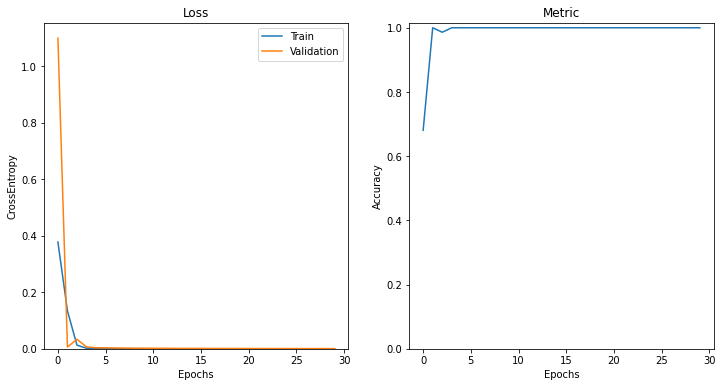

In [10]:
parser = ClassifierOptions()
parser.rewrite_option("name","us_class_try")
parser.rewrite_option("crop_dynamic_range", (0,255))
parser.rewrite_option("n_classes", 6)
parser.rewrite_option("loss_function", "CrossEntropy")
parser.rewrite_option("num_threads", 4)
parser.rewrite_option("epochs", 30)
parser.print_options()

transforms = [
    Resize(parser.image_size),
    DynamicRangeScaling(parser.model_dynamic_range,parser.crop_dynamic_range)
]

train_dataset = UsDataset(train_data, label_dict=labels, transforms=transforms)
validation_dataset = UsDataset(validation_data, label_dict=labels, transforms=transforms)

model = ImageClassifier(parser)
trainer = ClassifierTrainer(model)
trainer.set_dataloaders(train_dataset, validation_dataset)
trainer.train_model()
fig = trainer.plot_losses()



## 3. Let's Play with the model

Once we have a good model trained in classify Us images, we can start to explore its performance over the differente labels in the original test set. Also we are going to see its behaviour with the transformed data that emulates another Us machine operating a different frequency and gain.

But first, let's load the model and design a valiadation procedure

In [2]:
from typing import List

model_path = "saved_models/us_class_try"
parser, model = ImageClassifier.load_pretrained_model(model_path)
transforms = Compose([
    Resize(parser.image_size),
    DynamicRangeScaling(parser.model_dynamic_range, parser.crop_dynamic_range)
])

def get_validation_stats(validation_data: List[Ultrasound], title:str) -> None:

    classification_stats = defaultdict(list)
    for data in validation_data:
        us = transforms(data.torch_tensor)
        predict = model.inference(us.unsqueeze(0).float())
        success = inverse_labels[predict]==data.label
        classification_stats[data.label].append(int(success))
        if not success:
            #fig = data.plot(f"Real:{data.label} -> Predict:{inverse_labels[predict]}", figsize=(3,3))
            pass

    classification_stats = {k: np.mean(v) for k,v in classification_stats.items()}
    fig, ax = plt.subplots(1,1)
    ax.bar(classification_stats.keys(), classification_stats.values())  
    ax.set_ylabel("Classification success")
    ax.set_title(title)

-----------------------MODEL OPTIONS------------------------
Name                     ---->             us_class_try
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       30
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)



Now, we need to create the simulated data we have talken about above.

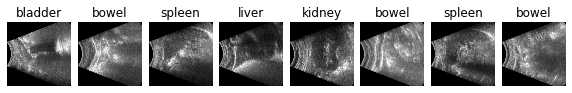

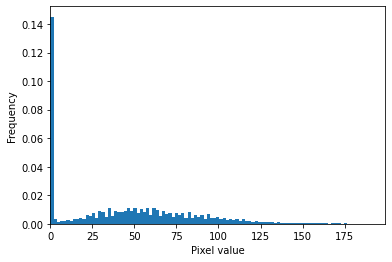

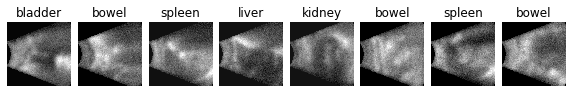

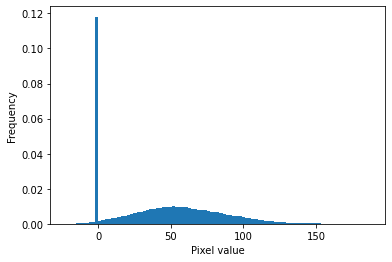

In [3]:
domain_transform = Compose([
    AxisTranspose([1]),
    Blur(1.5),
    RandomNoise(0,15) 
])

data = load_us_data()
adapted_data = [Ultrasound(domain_transform(us.torch_tensor), us.label, us.cone_array) for us in data]
for us in adapted_data:
    us.dark_cone()

for dataset in [data, adapted_data]:
    fig = Image.create_image_grid(dataset[::50])
    hist = obtain_histogram(dataset, 40)

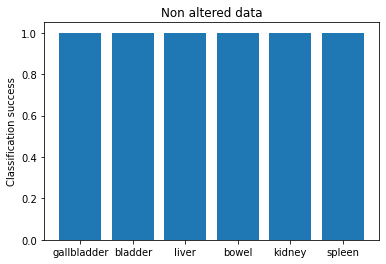

In [4]:
train_data, validation_data = split_us_dataset(data, labels=labels.keys(), validation_fraction=0.2)
get_validation_stats(validation_data, "Non altered data")

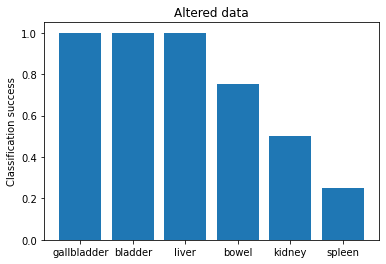

In [6]:
train_data, validation_data = split_us_dataset(adapted_data, labels.keys(), 0.2)
get_validation_stats(validation_data, "Altered data")

In [7]:
from collections import Counter
import os

def save_us_dataset(data:List[Ultrasound], dirpath:str):
    counter = Counter()
    for us in data:
        counter[us.label] += 1
        us.save_image(dirpath, file_name=f"{us.label}-{str(counter[us.label]).zfill(4)}.png", pil_convert_mode="L")

folders = ["trainA", "trainB", "testA", "testB"]
for folder in folders:
    os.makedirs(f"data_for_cyclegan/{folder}")

original_train_data, original_validation_data = split_us_dataset(data, labels.keys(), validation_fraction=0.05)
adapted_train_data, adapted_validation_data = split_us_dataset(adapted_data, labels.keys(), validation_fraction=0.05)

save_us_dataset(original_train_data, "data_for_cyclegan/trainA")
save_us_dataset(adapted_train_data, "data_for_cyclegan/trainB")
save_us_dataset(original_validation_data, "data_for_cyclegan/testA")
save_us_dataset(adapted_validation_data, "data_for_cyclegan/testB")




## 4. Data Harmonization

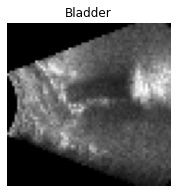

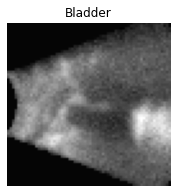

In [4]:
us = data[0]
us_trans = adapted_data[0]
_ = us.plot(figsize=(3,3))
_ = us_trans.plot(figsize=(3,3))

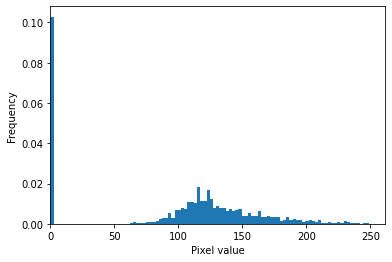

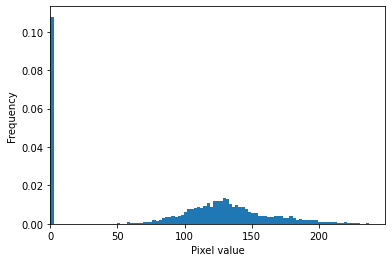

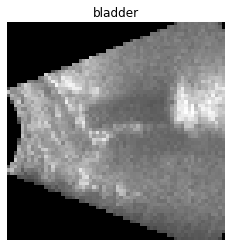

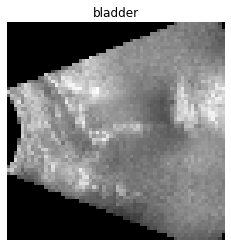

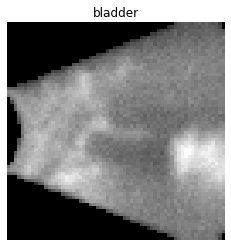

In [9]:
import torch
import matplotlib.pyplot as plt

from src.data.data_transforms import FDATransform

trans = FDATransform(us_trans.torch_tensor, L=0.06)
FDA_us = Ultrasound(trans(us.torch_tensor), us.label, us.cone_array)
FDA_us.dark_cone()
f = obtain_histogram([us], 1)
f = obtain_histogram([FDA_us], 1)

f = us.plot(figsize=(4,4))
f = FDA_us.plot(figsize=(4,4))
f = us_trans.plot(figsize=(4,4))